## Definitions

- Strike Price: This is the price at which our option is exercised at
- Underlying: This refers to the asset (which could really be anything which has a price) which underlies the derivative contract.
- ITM (In-the-money): An option is ITM if it is currently “worth” exercising today i.e. for a call option the current underlying’s price is greater than the strike price (and vice versa for a put).
- OTM (Out-of-the-money): An option is OTM if it is currently “not worth” exercising today.
- ATM (At-the-money): An option is ATM if it is neither ITM or OTM, i.e. exercising today would have no tangible effect (ignoring any transaction costs/option premiums).

In [3]:
%matplotlib widget

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

### Params

In [5]:
# ---------------------
# Define parameters
# ---------------------
r = 0.02      # risk-free rate
sigma = 0.14   # volatility
K = 100       # strike price
T = 1.0       # maturity in years
S_min, S_max = 0, 150   # range for underlying price S
N_S = 100              # number of S grid points
N_t = 100              # number of time grid points

n_sims = 10_000 # for monte carlo

In [6]:
def plotter(title, S_vals,t_vals,call_values):
    # Note: We'll plot with S on one axis, t on another, and call value on the z-axis.
    S_grid, t_grid = np.meshgrid(S_vals, t_vals)  # 2D coordinate arrays
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # IMPORTANT: call_values is indexed as [S_index, t_index],
    # but meshgrid returns [t, S] in (t_grid, S_grid).
    # So we either transpose call_values or swap the axes before plotting.
    # We'll transpose call_values so Z matches X=S_grid, Y=t_grid.
    surf = ax.plot_surface(S_grid, t_grid, call_values.T, cmap='viridis')
    
    ax.set_title(title)
    ax.set_xlabel("Underlying Price S")
    ax.set_ylabel("Time t")
    ax.set_zlabel("Option Value")
    
    ax.view_init(elev=-2, azim=88)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Modeling an Option with Geometric Brownian Motion

When pricing options in the classical Black–Scholes framework, the underlying asset price $S_t$ is assumed to follow a **Geometric Brownian Motion** under the **risk-neutral measure**. 

---

## 1. Dynamics Under the Risk-Neutral Measure

Under the risk-neutral measure $Q$, the asset price $S_t$ satisfies the **Stochastic Differential Equation (SDE)**:

$$
\mathrm{d}S_t = r \, S_t \,\mathrm{d}t \;+\; \sigma \, S_t \,\mathrm{d}W_t, 
\quad S_0 = s_0 > 0,
$$

where:
- $r$ is the **risk-free interest rate**,
- $\sigma$ is the **volatility**,
- $W_t$ is a **standard Brownian motion** under $Q$.

The **closed-form solution** to this SDE is:

$$
S_t 
= s_0 \exp\!\Bigl(\bigl(r - \tfrac{1}{2}\sigma^2\bigr)\,t \;+\; \sigma\,W_t\Bigr).
$$

Because of the exponential form, $S_t$ remains **strictly positive** for all $t \ge 0$.

---

## 2. European Call Option Pricing

A **European call option** with strike $K$ and maturity $T$ has the payoff 
$$
\max(S_T - K,\, 0).
$$

Under the risk-neutral valuation approach, the **fair price** of the option at time 0 is the discounted expected payoff:

$$
\text{Call}(0) 
= e^{-\,r\,T}\,\mathbb{E}^{Q}\bigl[\max(S_T - K,\, 0)\bigr].
$$

Using properties of the lognormal distribution of $S_T$, one arrives at the **Black–Scholes formula**:

$$
\text{Call}(0) 
= s_0 \,\Phi(d_1) - K \, e^{-r\,T}\,\Phi(d_2),
$$

where 
$$
d_1 = \frac{\ln\!\bigl(\tfrac{s_0}{K}\bigr) + \bigl(r + \tfrac{\sigma^2}{2}\bigr)\,T}{\sigma \,\sqrt{T}},
\quad 
d_2 = d_1 - \sigma \,\sqrt{T},
$$

and $\Phi(\cdot)$ is the **cumulative distribution function** of the standard normal distribution.

---

### Why Does GBM Help Avoid Negative Values?
- The price process $S_t$ in GBM has an **exponential** form, ensuring it remains **strictly positive**.
- This is crucial for modeling asset prices like stocks, which cannot go below zero.
- Under the **risk-neutral measure**, the drift becomes $r$ instead of the asset’s real-world expected return $\mu$.
- This change allows us to use a **discounted expectation** to price the option, leading to the **Black–Scholes formula**.


/var/folders/5_/86x7msms3b9d5qzksrmtsl6c0000gn/T/ipykernel_68745/291369650.py:16: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


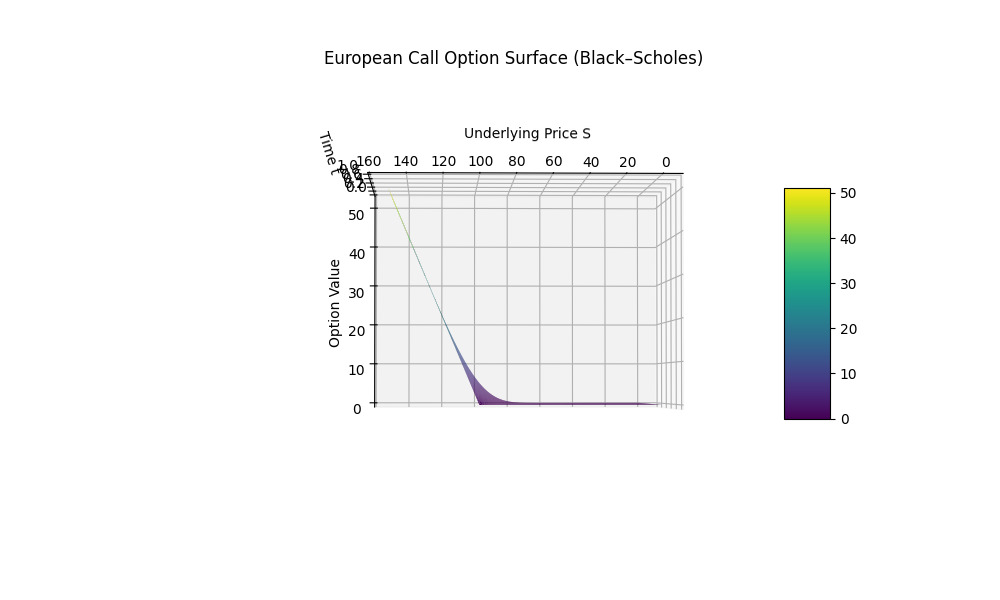

In [7]:
# Black–Scholes pricing of a European call at time t, with underlying price S

# ----------------------
# 1. Define the BS Call
# ----------------------
def black_scholes_call(S, K, r, sigma, tau):
    """
    Black–Scholes formula for a European call.
    tau = time to maturity = T - t
    """
    # If no time left, option value is just its intrinsic value:
    if tau <= 0:
        return max(S - K, 0)
    
    # Log of (S/K)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return (S * norm.cdf(d1) 
            - K * np.exp(-r * tau) * norm.cdf(d2))

# ----------------------------------------------
# 2. Create mesh grids for S (price) and t (time)
# ----------------------------------------------
S_vals = np.linspace(S_min, S_max, N_S)
t_vals = np.linspace(0, T, N_t)

# We'll store the option values in a 2D array:
call_values = np.zeros((N_S, N_t))

# For each S and t, compute the call price
for i, S in enumerate(S_vals):
    for j, t in enumerate(t_vals):
        tau = T - t  # time to maturity
        call_values[i, j] = black_scholes_call(S, K, r, sigma, tau)


plotter("European Call Option Surface (Black–Scholes)", S_vals, t_vals,call_values);

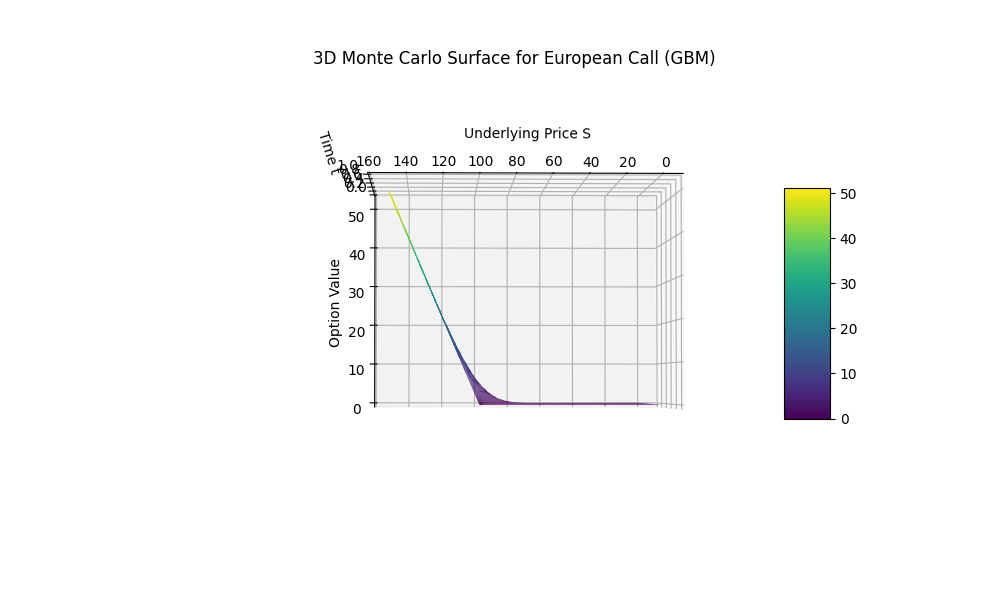

In [9]:
# Monte Carlo pricing of a European call at time t, with underlying price S
# Uses the direct (single-step) lognormal simulation from t to T
def mc_call_value(S, K, r, sigma, t, T, n_sims=10_000):
    """
    Return the Monte Carlo estimate of the European call value at time t,
    given current underlying price S, strike K, interest rate r,
    volatility sigma, maturity T, and number of simulations n_sims.
    """
    tau = T - t  # time to maturity
    if tau <= 0:
        # If we are at or past maturity, the option value is just its payoff now
        return max(S - K, 0)
    
    # Generate N(0,1) random variables
    Z = np.random.randn(n_sims)

    # GBM from time t to T (single-step exact solution)
    S_T = S * np.exp((r - 0.5*sigma**2)*tau + sigma * np.sqrt(tau)*Z)

    # Payoff = max(S_T - K, 0)
    payoff = np.maximum(S_T - K, 0.0)

    # Discounted payoff = e^{-r (T - t)} * payoff
    discounted = np.exp(-r * tau) * payoff

    # Monte Carlo estimator = average discounted payoff
    return np.mean(discounted)

# ----------------------------------------------
# 2. Create mesh grids for S (price) and t (time)
# ----------------------------------------------
S_vals = np.linspace(S_min, S_max, N_S)
t_vals = np.linspace(0, T, N_t)

# We'll store the option values in a 2D array:
call_surface = np.zeros((N_S, N_t))

# Fill in the surface by Monte Carlo
for i, S_now in enumerate(S_vals):
    for j, t_now in enumerate(t_vals):
        call_surface[i, j] = mc_call_value(
            S=S_now,
            K=K,
            r=r,
            sigma=sigma,
            t=t_now,
            T=T,
            n_sims=n_sims
        )

plotter("3D Monte Carlo Surface for European Call (GBM)", S_vals, t_vals, call_surface)